In [24]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

%load_ext autoreload
%autoreload 2
from utils import process_articles_directory
from utils import articles_to_embeddings
from utils import preprocessing_links
from utils import create_graph
from utils import visualization
from sentence_transformers import SentenceTransformer, util

In [2]:
data_path = os.path.abspath(os.path.join(os.getcwd(), 'data'))
articles_path = os.path.join(data_path, 'plaintext_articles')

result = process_articles_directory(articles_path)
df = pd.DataFrame(result, columns=['Article_Title', 'Related_Subjects', 'Description'])
print(f"There are : {len(df)} articles")
df.head()

There are : 4598 articles


,Article_Title,Related_Subjects,Description
0,Áedán mac Gabráin,[British History 1500 and before (including Ro...,"Áedán mac Gabráin was king of Dál Riata, a kin..."
1,Åland,"[Countries, European Countries]","Åland (pronounced IPA: ['oːland] in Swedish), ..."
2,Édouard Manet,[Artists],"Édouard Manet ( January 23, 1832 – April 30, 1..."
3,Éire,"[Countries, European Countries]",Éire ( pronounced [ˈeːrʲə]) is the Irish name ...
4,Óengus I of the Picts,[British History 1500 and before (including Ro...,"Óengus, son of Fergus ( Hypothetical Pictish f..."


In [3]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [4]:
df['Article_Title_embedding'] = df['Article_Title'].apply(model.encode, engine='numba', engine_kwargs={'parallel':True})
df['Description_embedding'] = df['Description'].apply(model.encode, engine='numba', engine_kwargs={'parallel':True})

In [5]:
for row in df.itertuples():
    score = util.dot_score(row.Article_Title_embedding,row.Description_embedding)
    if score < 0.2:
        print(f"{row.Article_Title} score: {score}")
        print(f"Description: {row.Description}")

Amur score: tensor([[0.1967]])
Description: The Amur River (Russian: Амур; Simplified Chinese: 黑龙江; Traditional Chinese: 黑龍江; pinyin: Hēilóng Jiāng, or "Black Dragon River"; Mongolian: Хара-Мурэн, Khara-Muren or "Black River"; Manchu: Sahaliyan Ula, literal meaning "Black River") is Earth's eighth longest river, forming the border between the Russian Far East and Manchuria in China.
Cheers score: tensor([[0.1901]])
Description: Cheers was an American situation comedy produced by Charles-Burrows-Charles Productions in association with Paramount Television for NBC. Cheers was created by the team of James Burrows, Glen Charles, and Les Charles. The show was set in the eponymous Cheers bar (itself named for the toast " Cheers") in Boston, Massachusetts, where a group of locals met to drink and generally have fun. The show's theme song was written and performed by Gary Portnoy with its famous refrain, "where everybody knows your name", that also became the show's tagline.


In [6]:
def compare_cosines(tup1, tup2):
    tup1_emb1 = tup1['Article_Title_embedding'].iloc[0]
    tup2_emb1 = tup2['Article_Title_embedding'].iloc[0]

    tup1_emb2 = tup1['Description_embedding'].iloc[0]
    tup2_emb2 = tup2['Description_embedding'].iloc[0]
    print(f"Cosine similarity between article names: {float(util.dot_score(tup1_emb1, tup2_emb1)):.4f}")
    print(f"Cosine similarity between descriptions: {float(util.dot_score(tup1_emb2, tup2_emb2)):.4f}")


In [7]:
# Both are science fiction writers. Using only their names, the cosine similarity
# is low. But with more context, their cosine similarity is high. They are indeed
# bi-directionally linked as they had influence in each other's lives.
print("John Campbell and Isaac Asimov comparison")
john = df[df['Article_Title'] == "John W. Campbell"]
isaac = df[df['Article_Title'] == "Isaac Asimov"]
compare_cosines(john, isaac)

# It can also help to disambiguate: a limerick is a form of poetry, so these two
# should be linked if we only take into account the article name. But the Limerick
# article actually talks about the city in Ireland, not the form of poetry.
print("\nLimerick and Poetry comparison")
limerick = df[df['Article_Title'] == "Limerick"]
poetry = df[df['Article_Title'] == "Poetry"]
compare_cosines(limerick, poetry)

# In the case where the articles should be linked but the description isn't similar
# like winter and summer which are opposing, the description cosine similarity is
# lower, but closer to the article name similarity than in the case of disambiguation.
print("\nWinter and Summer comparison")
winter = df[df['Article_Title'] == "Winter"]
summer = df[df['Article_Title'] == "Summer"]
compare_cosines(winter, summer)

John Campbell and Isaac Asimov comparison
Cosine similarity between article names: 0.2764
Cosine similarity between descriptions: 0.5171

Limerick and Poetry comparison
Cosine similarity between article names: 0.5433
Cosine similarity between descriptions: 0.1685

Winter and Summer comparison
Cosine similarity between article names: 0.6008
Cosine similarity between descriptions: 0.4943


Intuitively, articles should be linked if the cosine similarity between descriptions is higher than a certain threshold, while being close tothe article names cosine similarity. But it is easier to let a neural network determine the weights while passing on both the article names and descriptions embeddings as variables for each node.

In [8]:
embedded_articles=articles_to_embeddings(articles_path, model)

In [9]:
df_links = preprocessing_links(data_path)

In [10]:
df_links.head()

,Articles,Links
0,10th_century,"[11th_century, 9th_century, Algeria, Beer, Bla..."
1,11th_century,"[10th_century, 12th_century, 13th_century, 14t..."
2,12th_century,"[10th_century, 11th_century, 13th_century, 14t..."
3,13th_century,"[12th_century, 14th_century, Angola, Arabic_la..."
4,14th_century,"[13th_century, 15th_century, Abacus, Aztec, Bl..."


In [11]:
G=create_graph(embedded_articles, df_links)

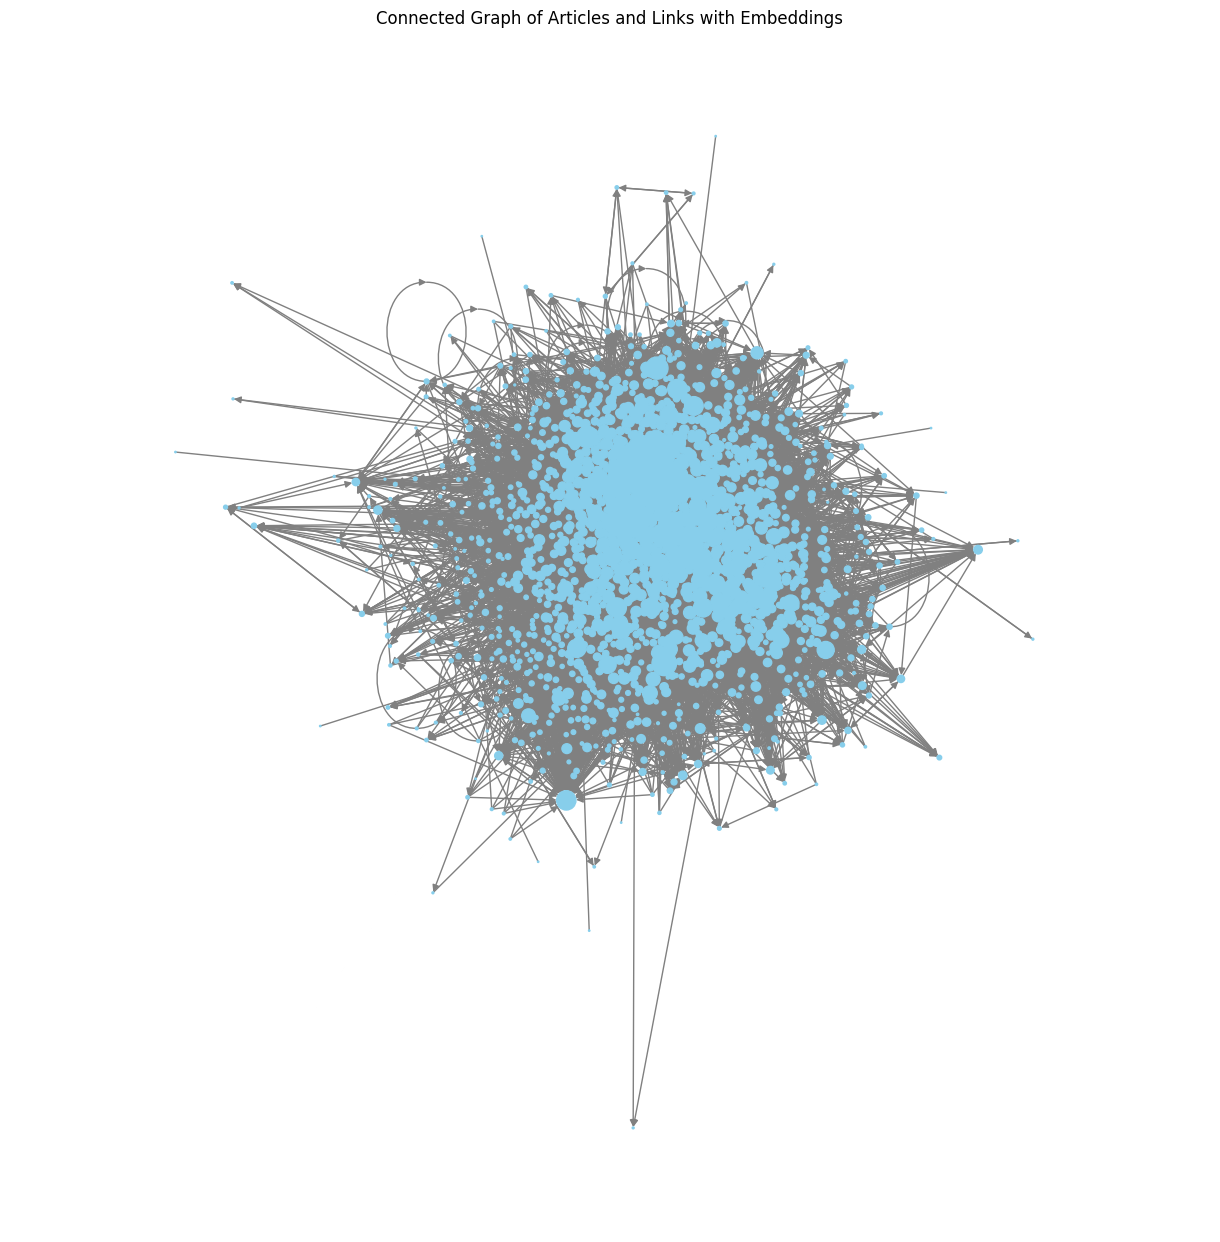

In [12]:
visualization(G)

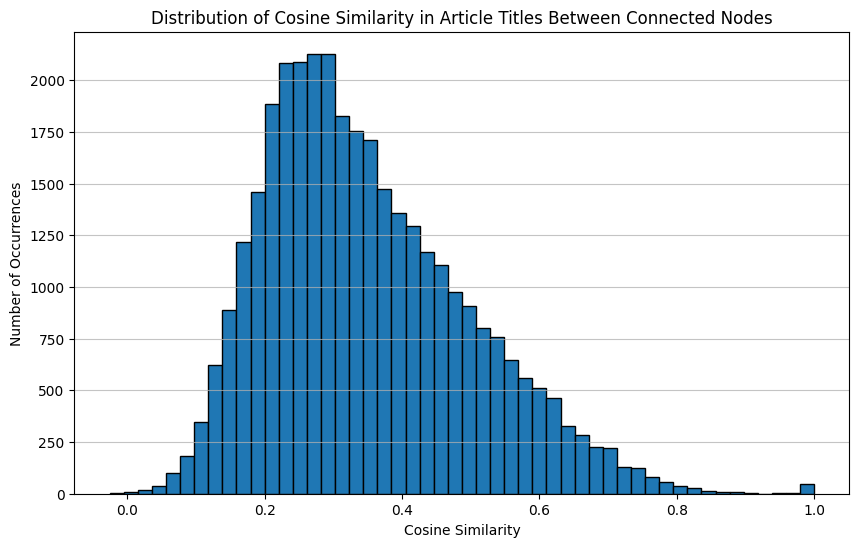

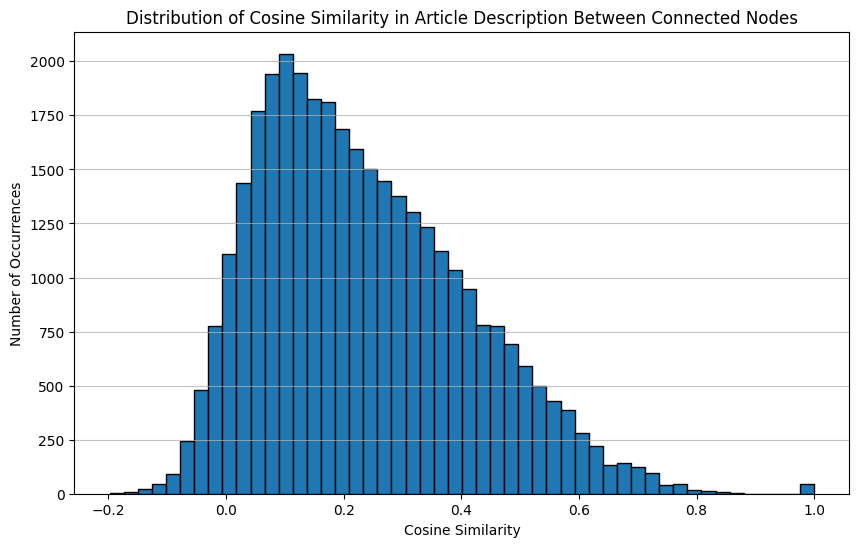

In [32]:
import matplotlib.pyplot as plt
# Extract weight_title values from the edges
weight_titles = [data['weght_title'] for _, _, data in G.edges(data=True)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(weight_titles, bins=50, edgecolor='black') 
plt.title('Distribution of Cosine Similarity in Article Titles Between Connected Nodes')
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of Occurrences')
plt.grid(axis='y', alpha=0.75)
plt.show()

weight_description = [data['weight_description'] for _, _, data in G.edges(data=True)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(weight_description, bins=50, edgecolor='black') 
plt.title('Distribution of Cosine Similarity in Article Description Between Connected Nodes')
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of Occurrences')
plt.grid(axis='y', alpha=0.75)
plt.show()